# Scanning Documents from Images

## Introduction

A number of camera apps in modern smartphones support document scanning. That is, taking a picture of a sheet of paper and getting a neat image of that page, looking like it was scanned with an image scanner.

While the general steps are easy to understand and implement, it is in fact a quite tough task to create a robust algorithm for this task. Since there is no control over the lighting conditions and the perspective, under which the image is captured, it is challenging to reliably detect the document properly. Not even to speak of background clutter.

The following sequence illustrates the general processing steps.

![](steps.png)

The first thing to do, is to find the outer contour of the document in the image. We exploit the fact that all edges of the document are still straight lines in the photograph. The intersections of those four lines are the detected corners of the document. (Image 2)

Using the coordinates of those four points, we can compute a transformation matrix which maps the document corners onto the corners of the image plane. (Image 3)

The last processing step is to digitally enhance the legibility of the scanned document. This includes sharpening, contrast increase and color correction. (Image 4)

## Preparation

We will use [scikit-image](https://scikit-image.org/) as a library for the image processing algorithm we will utilize for this project. It is advised to always have the [documentation](https://scikit-image.org/docs/stable/index.html) at hand.  
The `imread` function is used to load an image from disk.

In [5]:
from skimage.io import imread
image = imread("data/image.jpg")

Two of the most used python packages in scientific computing are [NumPy](https://numpy.org/) for working with MATLAB-like data structures and [matplotlib](https://matplotlib.org/) for data visualization. It's a more or less established convention to introduce NumPy as `np` and the pyplot frontend of matplotlib as `plt` into the namespace.

We additionally set some global parameters in order to display images nicer within a jupyter notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# set inline plotting for jupyter notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20] # make matplotlib display images larger
plt.rcParams['image.cmap'] = 'gray' # use grayscale for single channel images

The `imshow` function displays a scaled down version of the image. Note the axes showing the actual image dimensions. Counting starts in the top left corner and is consistent with the indices for matrix elements.

In [42]:
image.shape

(6000, 4000, 3)

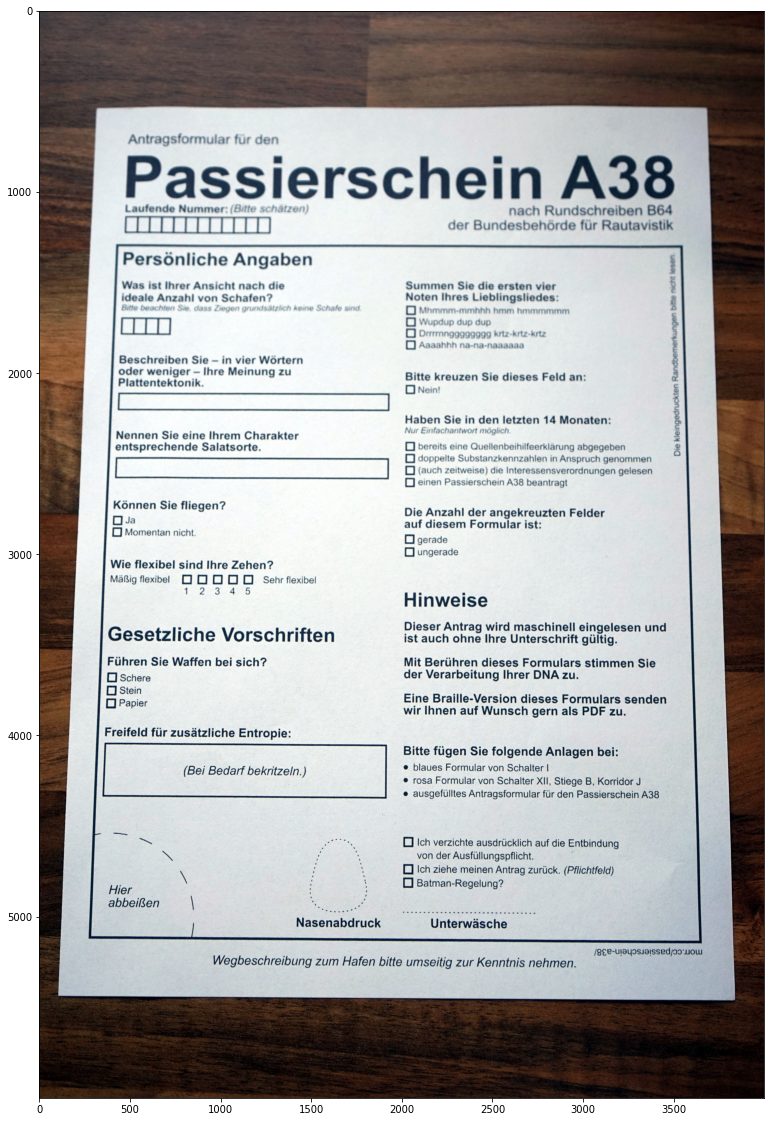

In [43]:
plt.imshow(image)

## Transforming the Image

As discussed earlier, the first step is to detect the edges and extract the corners of the document shown in the image. It is also the most challenging part, therefore we postpone it for didactical reasons and just assume that we already know the coordinates of the corner points.

The matrix `source_points` stores each point in a row, the first column being the x-coordinate and the second column the y-coordinate. Note that a consistent ordering of corner points is important. The first row represents the top left corner, then continuing in anti-clockwise direction.

In [44]:
source_points = np.array([[319, 545], [105, 5436], [3840, 5463], [3679, 538]])
print(source_points)

[[ 319  545]
 [ 105 5436]
 [3840 5463]
 [3679  538]]


Plotting the points on top of the image, we can confirm that those points are (approximately) correct.

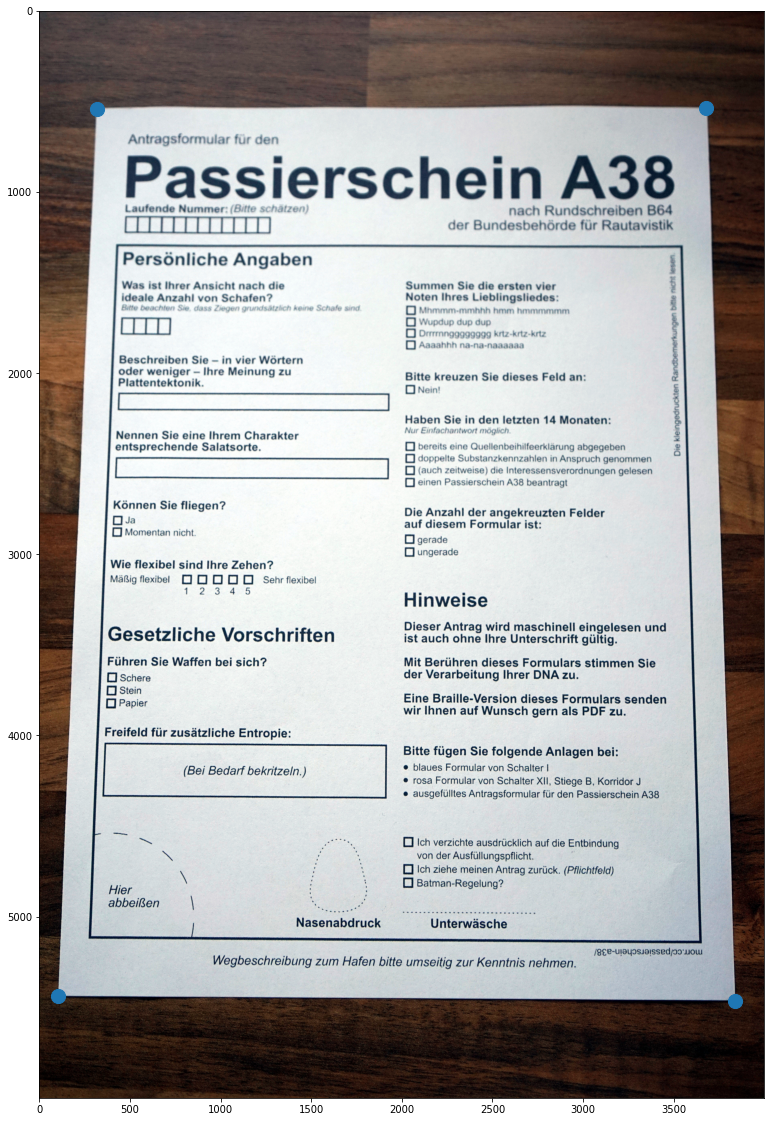

In [45]:
plt.imshow(image)
plt.scatter(source_points[:, 0], source_points[:, 1], s=200)

Knowing the source and destination of four points uniquely defines the transformation matrix for the projective transform of a two-dimensional image. In order to perform a four point transform we need to specify the destination coordinats for the corner points.

We simplify at this point and use the dimensions of the original image for the new corner points, with the same ordering scheme.

In [46]:
destination_points = np.array([[0, 0], [0, 6000], [4000, 6000], [4000, 0]])

This works out for this example since the aspect ratio of the picture is $2:3$ and quite close to the aspect ratio for an A4-page with $\frac{1}{\sqrt{2}}$.

Please note that is in general not the case, since we have no information about the dimensions, orientation and aspect ratio of the scanned document beforehand

The `transform` module in scikit-image has all the necessary tools to perform the projection step. We first estimate the transformation matrix from the source and destination points.

In [47]:
from skimage import transform

transformation_matrix = transform.ProjectiveTransform()
transformation_matrix.estimate(destination_points, source_points)
print(transformation_matrix)

<ProjectiveTransform(matrix=
    [[ 8.34155329e-01, -3.74189012e-02,  3.19000000e+02],
     [-2.60469773e-03,  7.24450984e-01,  5.45000000e+02],
     [-1.58865749e-06, -1.66879475e-05,  1.00000000e+00]])>


The transformation matrix fully specifies the perspective transform operation. We then call `warp` to compute the resulting image.

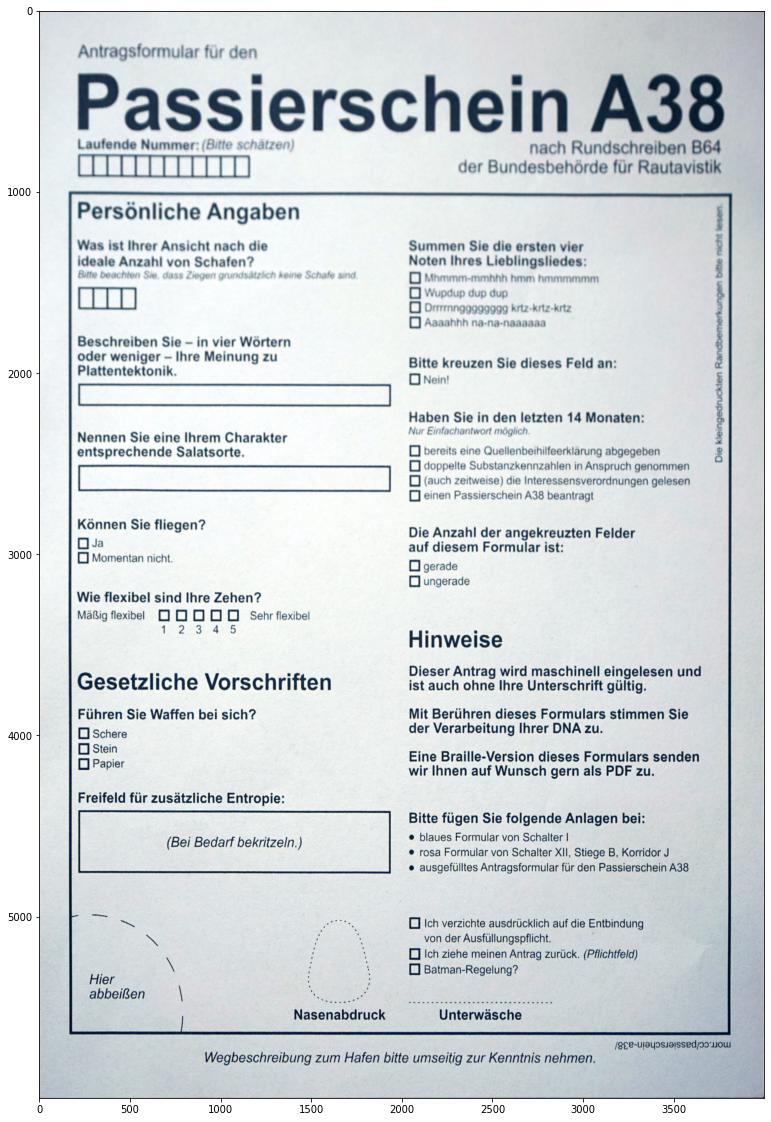

In [48]:
warped = transform.warp(image, transformation_matrix)
plt.imshow(warped)

## Enhancing the Scan

Since the resulting quality of the extracted document is almost always inferior to a scan performed on a flatbed scanner, it is reasonable to enhance the image. There are plenty operations one can consider here, we only want to exemplarily binarize the image here in order to maximize the contrast.

Since we are going to binarize the image anyhow, we perform a grayscale conversion first

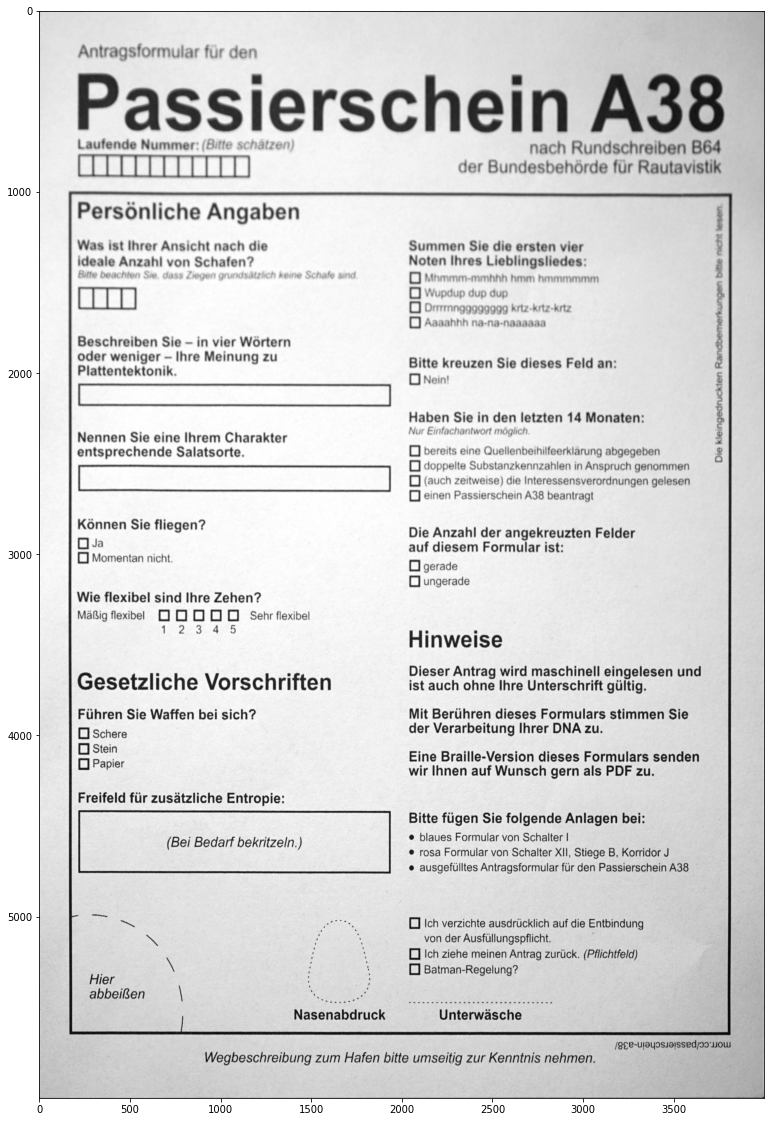

In [49]:
from skimage.color import rgb2gray
grayscale_image = rgb2gray(warped)
plt.imshow(grayscale_image)

The binarization step is a boolean operation for each pixel, comparing the value with a given threshold. We use the `threshold_mean` function to estimate a reasonable value for the threshold from the histogram of the image.

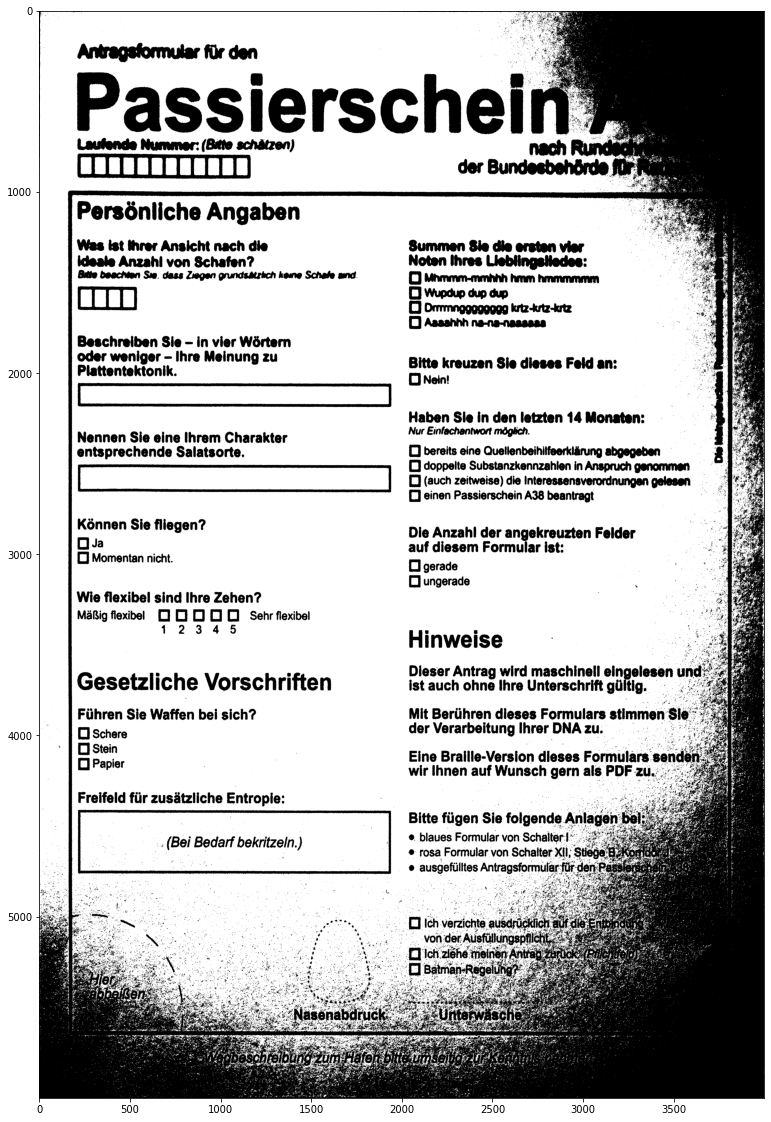

In [50]:
from skimage.filters import threshold_mean

thresh = threshold_mean(grayscale_image)
scan = grayscale_image > thresh
plt.imshow(scan)

The result is not very convincing. Can you improve it?  
How can we increase the contrast while preserving color?

As a final step we save the result back to disk. The explicit data type conversion is necessary¹, as the required data type for jpeg images are eight bit unsigned integers.

¹ It is in fact not really necessary, since `imsave` only throws a warning but still obediently performs the operation flawlessly.

In [58]:
from skimage.io import imsave
from skimage.util import img_as_ubyte
imsave("scan.jpg", img_as_ubyte(scan))

## Corner Detection

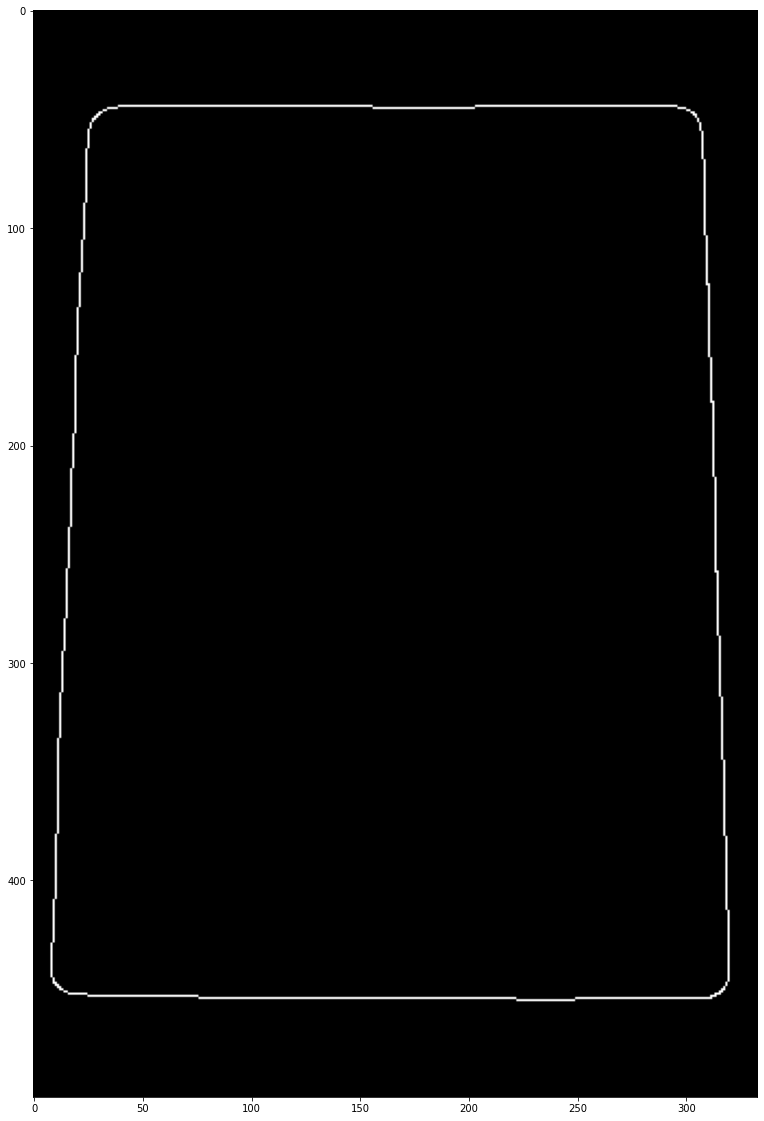

In [30]:
from skimage import feature
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread
image = imread("data/image.jpg")

image_grey = color.rgb2gray(image)
image_resized = resize(image_grey, (image.shape[0] // 12, image.shape[1] // 12),
                       anti_aliasing=False)
#plt.imshow(image_resized)
edges = feature.canny(image_resized, sigma=7.00)
plt.imshow(edges)



Text(0, 0.5, 'angle Δ')

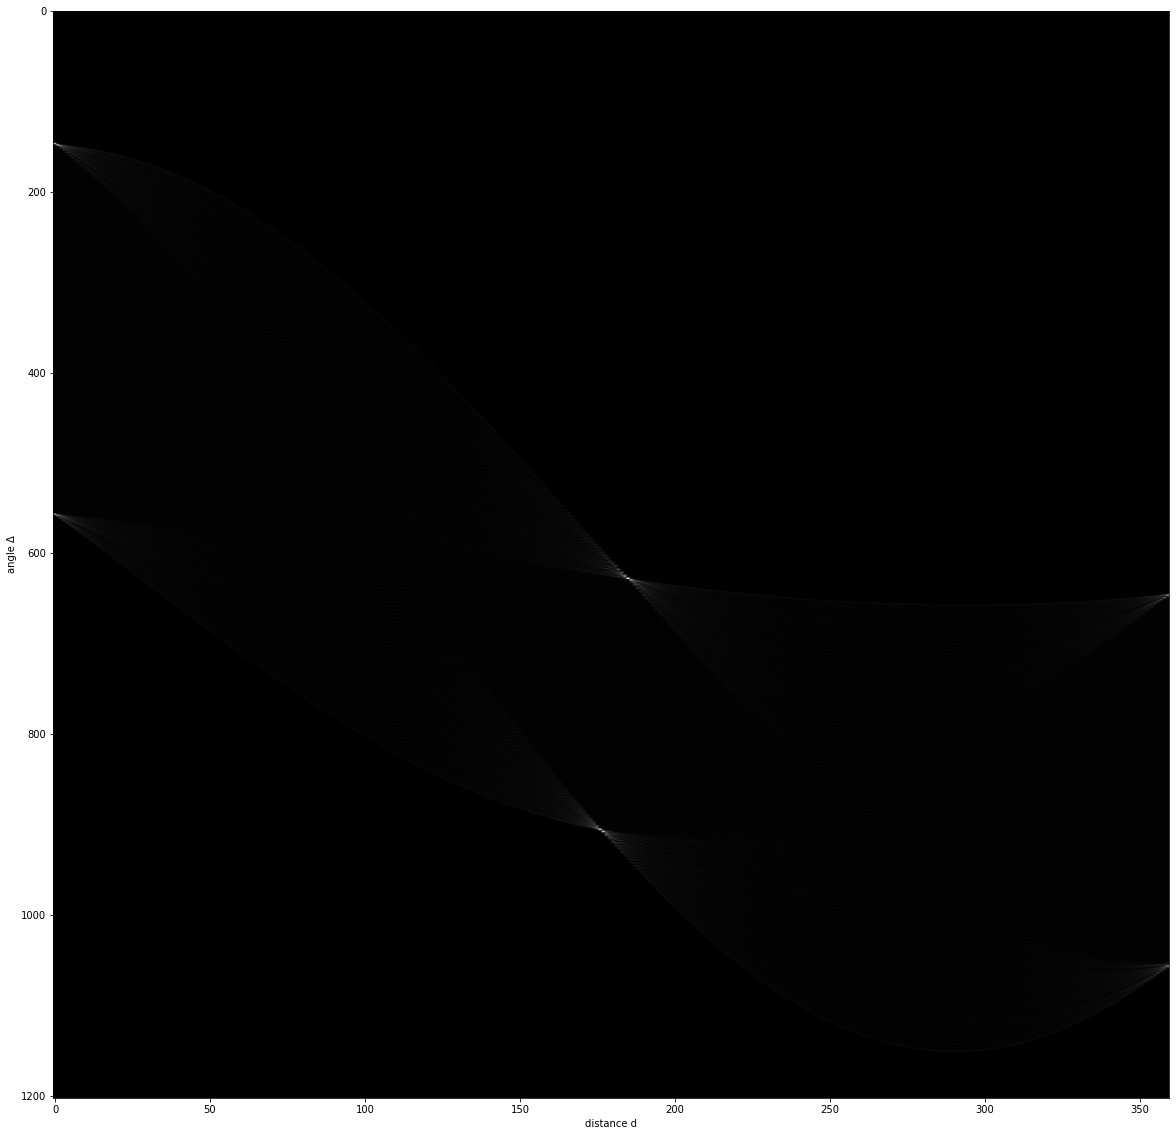

In [31]:
from skimage.transform import hough_line

tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edges, theta=tested_angles)
plt.imshow(h, aspect='auto')
plt.xlabel("distance d")
plt.ylabel("angle Δ")

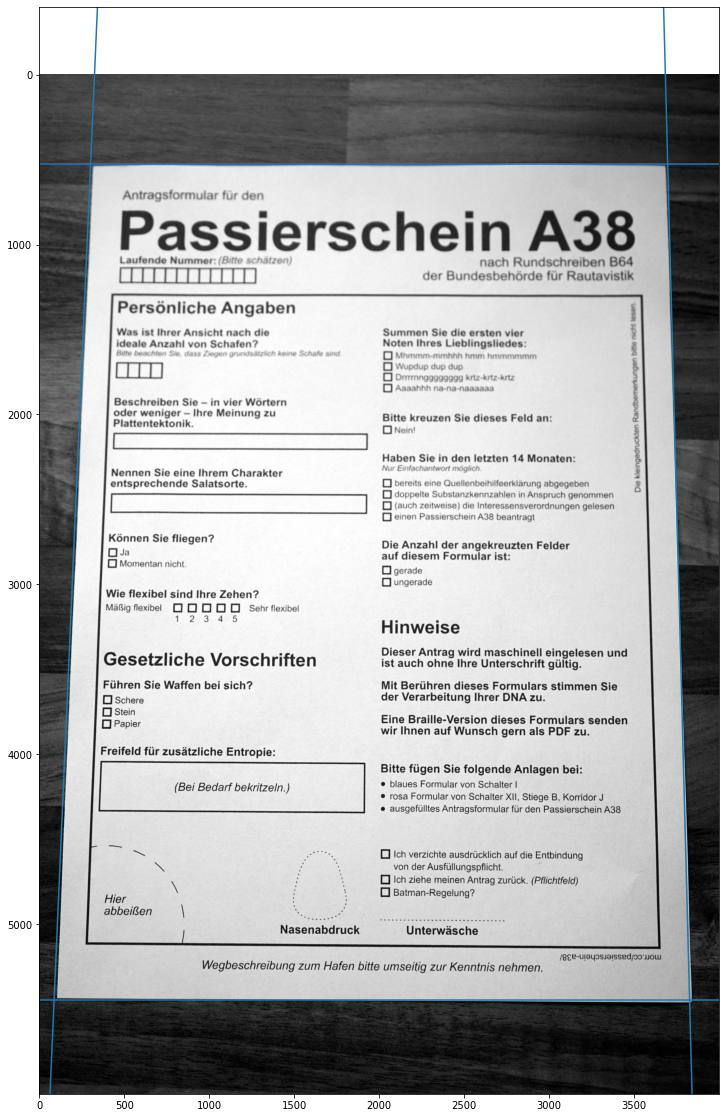

In [32]:
from skimage.transform import hough_line_peaks

hough_line_peaks(h, theta, d)
plt.imshow(image_grey)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=12, min_distance = 250)):
    (x0, y0) = 12 * dist * np.array([np.cos(angle), np.sin(angle)])
    plt.axline((x0, y0), slope=np.tan(angle + np.pi/2))